# Data driven approach

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib.animation as animation

# Import data
experiments = pd.read_csv("n73_stabilization.csv")
# NOTE: Fixed radius 16.75
experiments = experiments[['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']] # Columns of interest

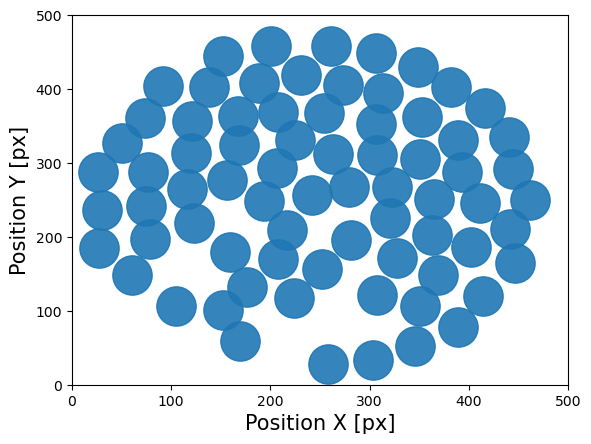

In [10]:
# Create trajectories animation

frames_num = len(pd.unique(experiments['FRAME']))

# Create a figure and axis
fig, ax = plt.subplots()
ax.set_xlabel('Position X [px]', fontsize=15)
ax.set_ylabel('Position Y [px]', fontsize=15)

# Create an empty scatter plot (initially no balls are shown)
scatter = ax.scatter([], [], s=800, alpha=0.9)
ax.set(xlim=[0, 500], ylim=[0, 500])

# Function to update the scatter plot with new ball positions
def update(frame):
    frame_df = experiments[experiments['FRAME'] == frame]
    x = frame_df['POSITION_X']
    y = frame_df['POSITION_Y']
    
    # update the scatter plot:
    data = np.stack([x, y]).T
    scatter.set_offsets(data)

    return scatter,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(frames_num), interval=50, blit=True)
#ani.save('animation.gif', writer='pillow')
plt.show()

In [11]:
# Data frame
vwr_df = pd.DataFrame(columns=['TRACK_ID', 'FRAME', 'POSITION_X', 'POSITION_Y',
                               'VELOCITY_X', 'VELOCITY_Y', 'VELOCITY_MAG', 
                               'RADIUS', 'ANGULAR_VELOCITY', 'ANGLE_DIFF'])
 
for a in pd.unique(experiments['TRACK_ID']):
    if not (a == 73):
        # Calculate v, w and r per agent
        agent = experiments[experiments['TRACK_ID'] == a]

        vel_x = np.zeros(len(agent['FRAME']))
        vel_y = np.zeros(len(agent['FRAME']))
        vel_mag = np.zeros(len(agent['FRAME']))

        ang = np.zeros(len(agent['FRAME']))
        ang_vel = np.zeros(len(agent['FRAME']))

        r = np.zeros(len(agent['FRAME']))

        ind_prev = agent[agent['FRAME'] == 0].index
        x_prev = agent.loc[ind_prev, 'POSITION_X'].iloc[0] - 240
        y_prev = agent.loc[ind_prev, 'POSITION_Y'].iloc[0] - 240

        r[0] =  np.sqrt(x_prev**2 + y_prev**2)
        r_prev = r[0]

        # Assume unit time step per frame
        frames = agent.sort_values(by='FRAME')['FRAME'].values
        for i in frames:
            ind = agent[agent['FRAME'] == i].index
            x = agent.loc[ind, 'POSITION_X'].iloc[0] - 240
            y = agent.loc[ind, 'POSITION_Y'].iloc[0] - 240

            vel_x[i] = x - x_prev
            vel_y[i] = y - y_prev
            vel_mag[i] = np.sqrt(vel_x[i]**2 + vel_y[i]**2)

            r[i] =  np.sqrt(x**2 + y**2)
            ang_vel[i] = vel_mag[i]/r[i]

            vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)
            angle_rad = np.arccos(vec_cos)
            ang[i] = np.degrees(angle_rad)

            # Update values
            ind_prev = ind
            x_prev = x
            y_prev = y
            r_prev = r[i]

        agent_df = pd.DataFrame({'TRACK_ID': agent['TRACK_ID'], 'FRAME': frames,
                                'POSITION_X': agent['POSITION_X'], 'POSITION_Y': agent['POSITION_Y'], 
                                'VELOCITY_X': vel_x, 'VELOCITY_Y': vel_y, 'VELOCITY_MAG': vel_mag, 
                                'RADIUS': r, 'ANGULAR_VELOCITY': ang_vel, 'ANGLE_DIFF': ang})
        
        vwr_df = pd.concat([vwr_df, agent_df], ignore_index=True)

/tmp/ipykernel_117455/3614100809.py:41: RuntimeWarning: invalid value encountered in scalar divide
  vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)
/tmp/ipykernel_117455/3614100809.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vwr_df = pd.concat([vwr_df, agent_df], ignore_index=True)


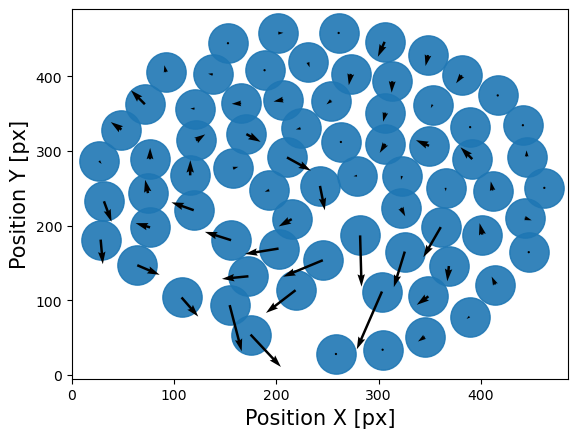

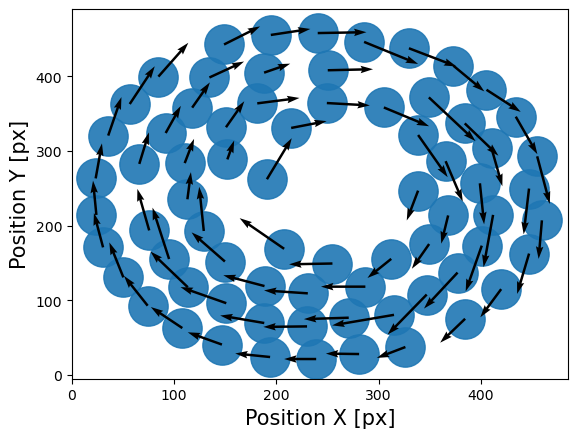

In [12]:
# Velocity field (order - disorder)
for i in [1, 1390]:
    frame_info = vwr_df[vwr_df['FRAME'] == i]

    # Create a scatter plot of positions
    # Marker size as: pi*r^2
    plt.scatter(frame_info['POSITION_X'], frame_info['POSITION_Y'], s=800, alpha=0.9)

    # Plot arrows representing velocity at each point
    plt.quiver(frame_info['POSITION_X'], frame_info['POSITION_Y'], 
               frame_info['VELOCITY_X'], frame_info['VELOCITY_Y'], 
               color='k', scale=16, scale_units='inches', width=0.005)

    # Set labels and title
    plt.xlim(0, 485)
    plt.ylim(-5, 490)
    plt.xlabel('Position X [px]', fontsize=15)
    plt.ylabel('Position Y [px]', fontsize=15)

    # Show plot
    plt.savefig(f'Vel_field{i}.pdf', format='pdf')
    plt.show()

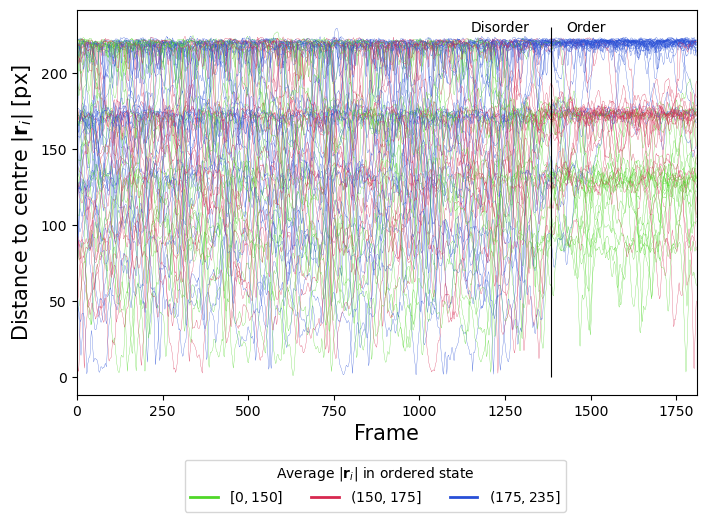

In [52]:
# Plot for radial distance plot
fig = plt.figure(figsize=(8, 5))

avg_angv = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for a in pd.unique(vwr_df['TRACK_ID']):
    agent_info = vwr_df[vwr_df['TRACK_ID'] == a]
    
    avg_end = agent_info[agent_info['FRAME'] > 1385]
    avg_end = np.mean(avg_end['RADIUS'])
    agent_level = '#4FD728'
    if avg_end>150: agent_level = '#D7284F'
    if avg_end>175: agent_level = '#284FD7'
    plt.plot(agent_info['FRAME'], agent_info['RADIUS'], linewidth=0.2, color=agent_level)

plt.xlim(0, 1810)
plt.vlines(x=1385, ymin=0, ymax=230, color='k', linewidth=0.8)
plt.annotate('Disorder', xy=(1150,227), color='k')
plt.annotate('Order', xy=(1430,227), color='k')
plt.ylabel('Distance to centre $\\vert\\mathbf{r}_i\\vert$ [px]', fontsize=15)
plt.xlabel('Frame', fontsize=15)

# Legend
# Colors for the levels
level_colors = {
    'Level 1': '#4FD728',
    'Level 2': '#D7284F',
    'Level 3': '#284FD7'
}

# Create proxy artists for the legend
proxy_artists = [
    plt.Line2D([0], [0], color=level_colors['Level 1'], lw=2),
    plt.Line2D([0], [0], color=level_colors['Level 2'], lw=2),
    plt.Line2D([0], [0], color=level_colors['Level 3'], lw=2)
]

# Add legend to the plot
plt.legend(proxy_artists, [
    '$[0, 150]$',
    '$(150, 175]$',
    '$(175, 235]$'
], fontsize=10, bbox_to_anchor=(0.8, -0.15), title='Average $\\vert\\mathbf{r}_i\\vert$ in ordered state', ncol=3)

plt.savefig('radius.pdf', format='pdf')
plt.show()

In [14]:
# 95% of the balls confidence interval
frames = np.array(pd.unique(vwr_df['FRAME']), dtype=int)

avg_speed = np.zeros(len(pd.unique(vwr_df['FRAME'])))
lower95 = np.zeros(len(pd.unique(vwr_df['FRAME'])))
upper95 = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in frames:
    frame_info = vwr_df[vwr_df['FRAME'] == i]
    avg_speed[i] = np.mean(frame_info['VELOCITY_MAG'])
    
    frame_speeds = np.sort(frame_info['VELOCITY_MAG'])
    lower95[i] = frame_speeds[1] # 2.5 % of 73 approx 2
    upper95[i] = frame_speeds[-2] # 2.5 % of 73 approx 2

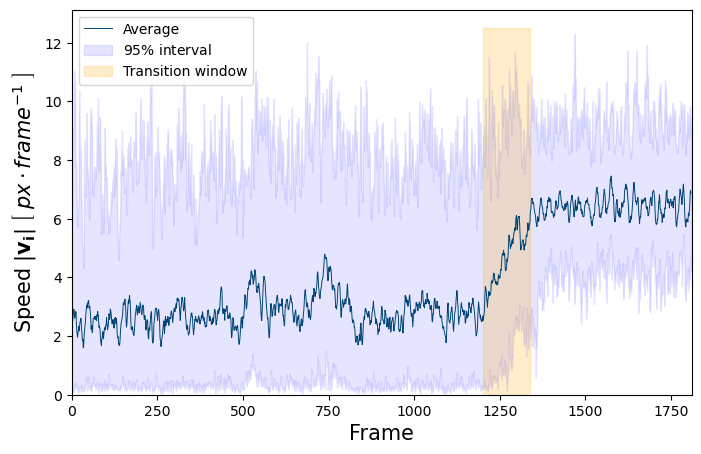

In [15]:
# Make pretty plots
fig = plt.figure(figsize=(8, 5))

# Units in SI 
plt.plot(frames[1:], avg_speed[1:], color='#004474', linewidth=0.7, label='Average')
plt.fill_between(frames[1:], lower95[1:], upper95[1:], color='blue', alpha=0.1, label='$95\\%$ interval')
plt.fill_between(np.arange(1200,1340), 0, 12.5, color='orange', alpha=0.2, label='Transition window')

plt.xlim(0, 1810)
plt.ylim(bottom=0)
plt.ylabel('Speed $\\vert\\mathbf{v_i}\\vert$ $\\left[ \\; px \cdot frame^{-1} \\; \\right]$', fontsize=15)
plt.xlabel('Frame', fontsize=15)
plt.legend(loc='upper left')
plt.savefig('speed.pdf', format='pdf')
plt.show()

In [16]:
# Plot for angle difference
avg_angv = np.zeros(len(pd.unique(vwr_df['FRAME'])))
ang_lower95 = np.zeros(len(pd.unique(vwr_df['FRAME'])))
ang_upper95 = np.zeros(len(pd.unique(vwr_df['FRAME'])))
ang_range = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    frame_info = vwr_df[vwr_df['FRAME'] == i]
    avg_angv[i] = np.mean(frame_info['ANGLE_DIFF'])

    #95% of the balls
    frame_angv = np.sort(frame_info['ANGLE_DIFF'])
    ang_lower95[i] = frame_angv[1] # 2.5 % of 73 approx 2
    ang_upper95[i] = frame_angv[-2] # 2.5 % of 73 approx 2
    ang_range[i] = ang_upper95[i] - ang_lower95[i]

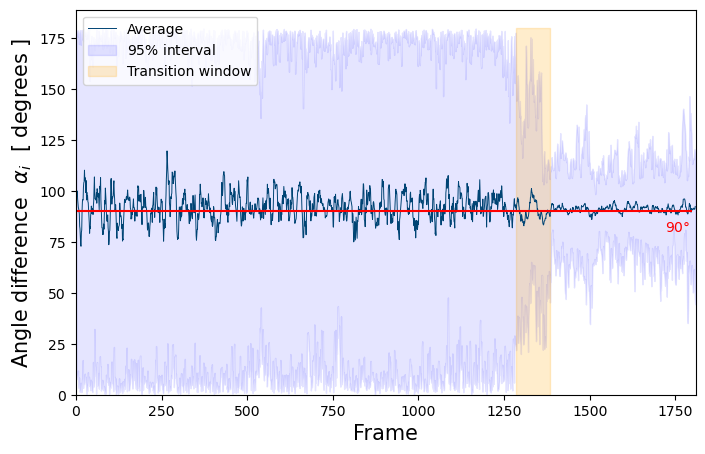

In [17]:
# Make pretty plots
fig = plt.figure(figsize=(8, 5))

plt.plot(frames[1:], avg_angv[1:], color='#004474', linewidth=0.7, label='Average')
plt.fill_between(frames[1:], ang_lower95[1:], ang_upper95[1:], color='blue', alpha=0.1, label='$95\\%$ interval')
plt.fill_between(np.arange(1285,1385), 0, 180, color='orange', alpha=0.2, label='Transition window')

plt.xlim(0, 1810)
plt.ylim(bottom=0)
plt.hlines(y=90, xmin=0, xmax=1800, color='r')
plt.annotate('$90\\degree$', xy=(1720,80), color='r')
plt.ylabel('Angle difference  $\\alpha_i$  [ degrees ]', fontsize=15)
plt.xlabel('Frame', fontsize=15)
plt.legend(loc='upper left')
plt.savefig('angle_diff95.pdf', format='pdf')
plt.show()

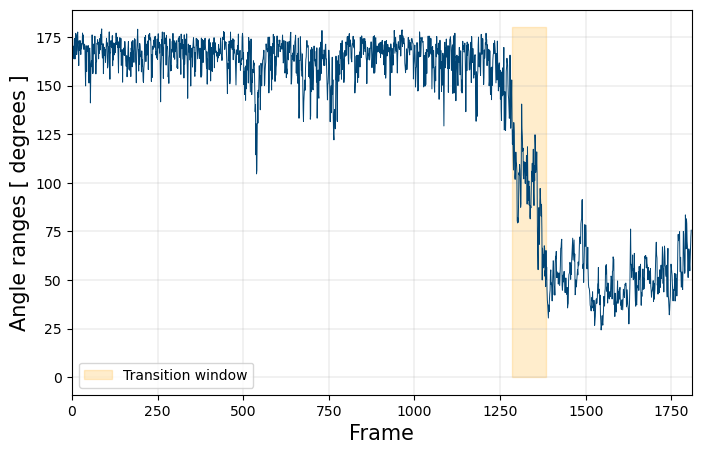

In [18]:
# Make pretty plots
fig = plt.figure(figsize=(8, 5))

plt.fill_between(np.arange(1285,1385), 0, 180, color='orange', alpha=0.2, label='Transition window')
plt.plot(frames[1:], ang_range[1:], color='#004474', linewidth=0.7)

plt.xlim(0, 1810)
plt.ylabel('Angle ranges [ degrees ]', fontsize=15)
plt.xlabel('Frame', fontsize=15)
plt.legend(loc='lower left')
plt.grid(linewidth=0.25)
plt.savefig('angle_range.pdf', format='pdf')
plt.show()

In [19]:
# Plot for angle difference
avg_angv25 = np.zeros(len(pd.unique(vwr_df['FRAME'])))
ang_lower25 = np.zeros(len(pd.unique(vwr_df['FRAME'])))
ang_upper25 = np.zeros(len(pd.unique(vwr_df['FRAME'])))
ang_range25 = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    frame_info = vwr_df[vwr_df['FRAME'] == i]
    avg_angv25[i] = np.mean(frame_info['ANGLE_DIFF'])

    #95% of the balls
    frame_angv = np.sort(frame_info['ANGLE_DIFF'])
    ang_lower25[i] = frame_angv[17] # 25% of 73 approx 18
    ang_upper25[i] = frame_angv[-18] # 25% of 73 approx 18
    ang_range25[i] = ang_upper25[i] - ang_lower25[i]

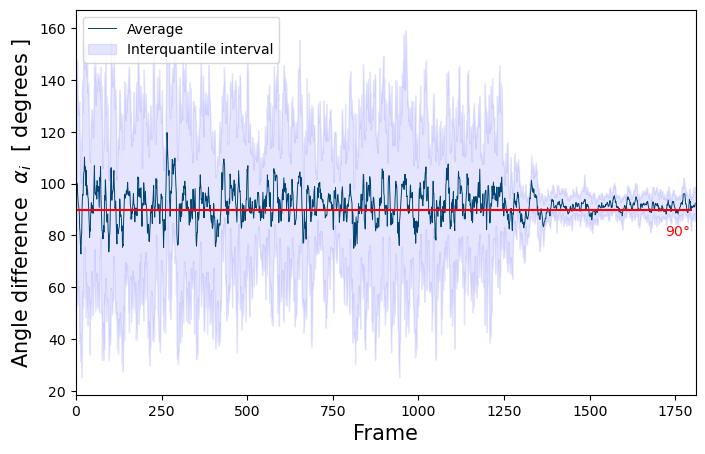

In [20]:
# Make pretty plots
fig = plt.figure(figsize=(8, 5))

plt.plot(frames[1:], avg_angv25[1:], color='#004474', linewidth=0.7, label='Average')
plt.fill_between(frames[1:], ang_lower25[1:], ang_upper25[1:], color='blue', alpha=0.1, label='Interquantile interval')

plt.xlim(0, 1810)
plt.hlines(y=90, xmin=0, xmax=1800, color='r')
plt.annotate('$90\\degree$', xy=(1720,80), color='r')
plt.ylabel('Angle difference  $\\alpha_i$  [ degrees ]', fontsize=15)
plt.xlabel('Frame', fontsize=15)
plt.legend(loc='upper left')
plt.savefig('angle_diff95.pdf', format='pdf')
plt.show()

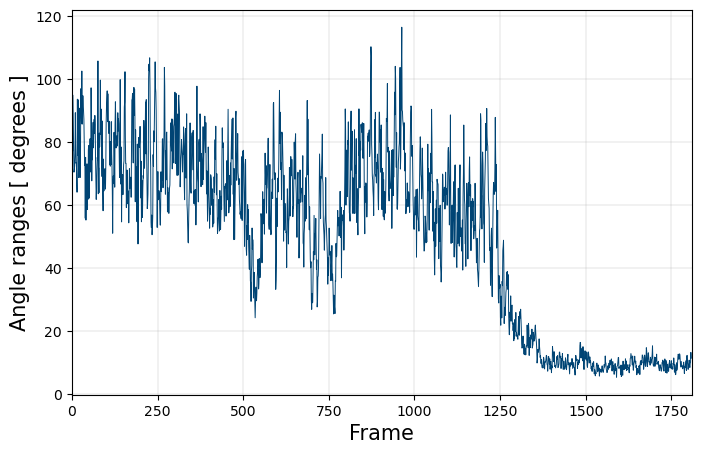

In [21]:
# Make pretty plots
fig = plt.figure(figsize=(8, 5))

plt.plot(frames[1:], ang_range25[1:], color='#004474', linewidth=0.7)

plt.xlim(0, 1810)
plt.ylabel('Angle ranges [ degrees ]', fontsize=15)
plt.xlabel('Frame', fontsize=15)
plt.grid(linewidth=0.25)
plt.savefig('angle_range.pdf', format='pdf')
plt.show()

In [30]:
max(frames)

1808

# Guess work

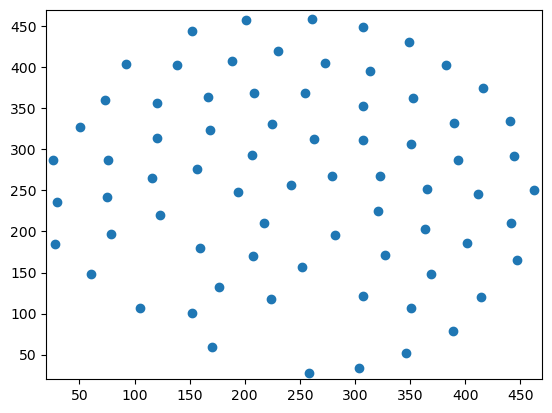

In [22]:
# Create trajectories animation

frames_num = len(pd.unique(experiments['FRAME']))

# Create a figure and axis
fig, ax = plt.subplots()

# Create an empty scatter plot (initially no balls are shown)
scatter = ax.scatter([], [])
ax.set(xlim=[20, 470], ylim=[20, 470])

# Function to update the scatter plot with new ball positions
def update(frame):
    frame_df = experiments[experiments['FRAME'] == frame]
    x = frame_df['POSITION_X']
    y = frame_df['POSITION_Y']

    # update the scatter plot:
    data = np.stack([x, y]).T
    scatter.set_offsets(data)

    return scatter,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(frames_num), interval=50, blit=True)
#ani.save('animation.gif', writer='pillow')
plt.show()

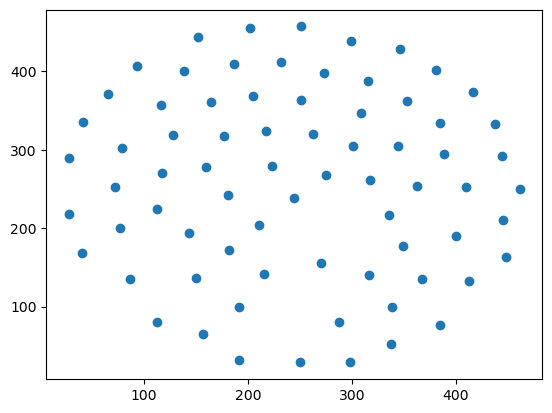

In [23]:
fig, ax = plt.subplots()
frame_ex = vwr_df[vwr_df['FRAME'] == 5]
ax.scatter(frame_ex['POSITION_X'], frame_ex['POSITION_Y'])
plt.show() 

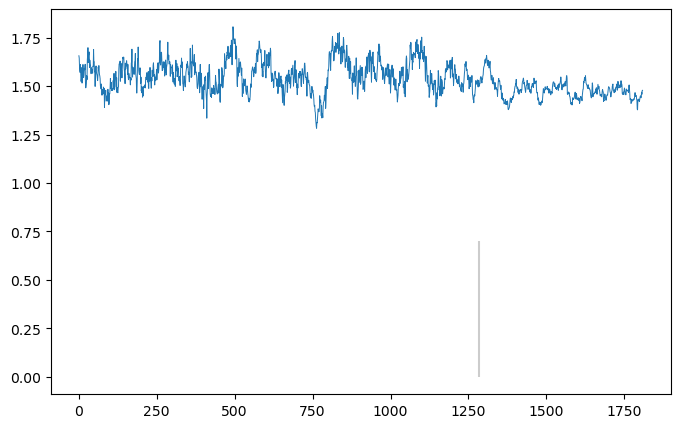

In [24]:
import cmath
# Create order parameter
order_max = np.zeros(len(pd.unique(vwr_df['FRAME'])))
order_min = np.zeros(len(pd.unique(vwr_df['FRAME'])))
S_plus = np.zeros(len(pd.unique(vwr_df['FRAME'])))
S_minus = np.zeros(len(pd.unique(vwr_df['FRAME'])))
S_sum = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    if not i == 0:
        frame_info = vwr_df[vwr_df['FRAME'] == i]
        W_plus = 0
        W_minus = 0
        for _, agent in frame_info.iterrows():
            phi = np.arctan(agent['POSITION_Y']/agent['POSITION_X'])
            if not agent['VELOCITY_X']==0:
                theta = np.arctan(agent['VELOCITY_Y']/agent['VELOCITY_X'])
            else:
                theta = np.pi/2 if agent['VELOCITY_Y']>0 else -np.pi
    
            W_plus += cmath.exp(1j*(phi+theta))
            W_minus += cmath.exp(1j*(phi-theta))
        
        W_plus = W_plus/(frame_info.size/10)
        W_minus = W_minus/(frame_info.size/10)
        
        S_plus[i] = cmath.phase(W_plus)
        S_minus[i] = cmath.phase(W_minus)

        order_max[i] = max(S_plus[i], S_minus[i])
        order_min[i] = min(S_plus[i], S_minus[i])

        S_sum[i] = S_plus[i] + S_minus[i]

fig = plt.figure(figsize=(8, 5))
#plt.fill_between(frames[1:], order_min[1:], order_max[1:], color='blue', alpha=0.1)
#plt.plot(frames[500:], S_plus[500:], linewidth=0.7, label='$S_{+}$')
#plt.plot(frames[500:], S_minus[500:], linewidth=0.7, label='$S_{-}$')
plt.vlines(x=1285, ymin=0, ymax=0.7, color='k', alpha=0.2)
plt.plot(frames[1:], S_sum[1:], linewidth=0.7, label='$S_{-}$')
plt.show()

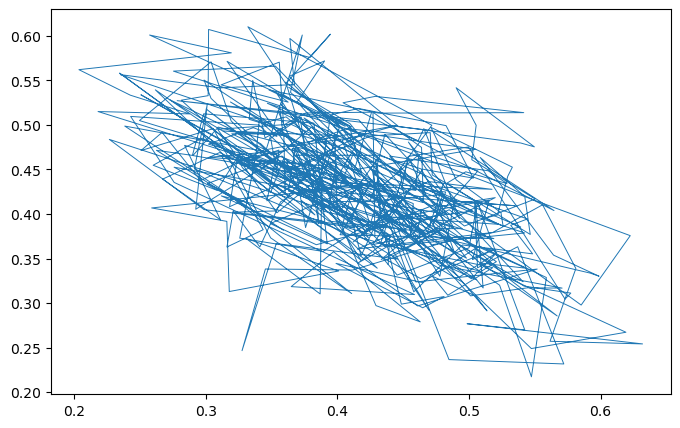

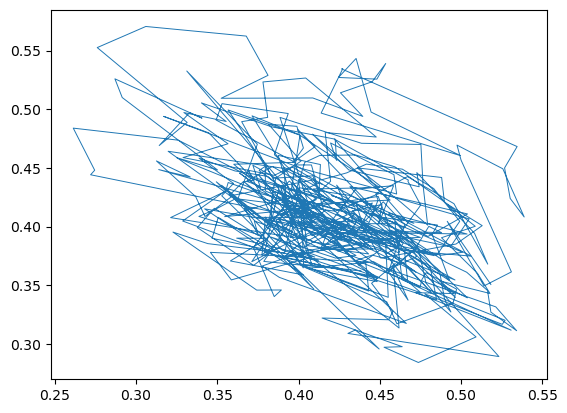

In [25]:
import cmath
# Create order parameter
x_plus = np.zeros(len(pd.unique(vwr_df['FRAME'])))
y_plus = np.zeros(len(pd.unique(vwr_df['FRAME'])))

x_minus = np.zeros(len(pd.unique(vwr_df['FRAME'])))
y_minus = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    if not i == 0:
        frame_info = vwr_df[vwr_df['FRAME'] == i]
        W_plus = 0
        W_minus = 0
        for _, agent in frame_info.iterrows():
            phi = np.arctan(agent['POSITION_Y']/agent['POSITION_X'])
            if not agent['VELOCITY_X']==0:
                theta = np.arctan(agent['VELOCITY_Y']/agent['VELOCITY_X'])
            else:
                theta = np.pi/2 if agent['VELOCITY_Y']>0 else -np.pi
    
            W_plus += cmath.exp(1j*(phi+theta))
            W_minus += cmath.exp(1j*(phi-theta))
        
        W_plus = W_plus/(frame_info.size/10)
        W_minus = W_minus/(frame_info.size/10)
        
        x_plus[i] = abs(W_plus)*np.cos(cmath.phase(W_plus))
        y_plus[i] = abs(W_plus)*np.sin(cmath.phase(W_plus))

        x_minus[i] = abs(W_minus)*np.cos(cmath.phase(W_minus))
        y_minus[i] = abs(W_minus)*np.sin(cmath.phase(W_minus))

        order_max[i] = max(S_plus[i], S_minus[i])
        order_min[i] = min(S_plus[i], S_minus[i])

        S_sum[i] = S_plus[i] + S_minus[i]

fig = plt.figure(figsize=(8, 5))
#plt.plot(x_plus[770:1285], y_plus[770:1285], linewidth=0.7)
plt.plot(x_minus[770:1285], y_minus[770:1285], linewidth=0.7)
plt.show()

#plt.plot(x_plus[1285:], y_plus[1285:], linewidth=0.7)
plt.plot(x_minus[1285:], y_minus[1285:], linewidth=0.7)
plt.show()

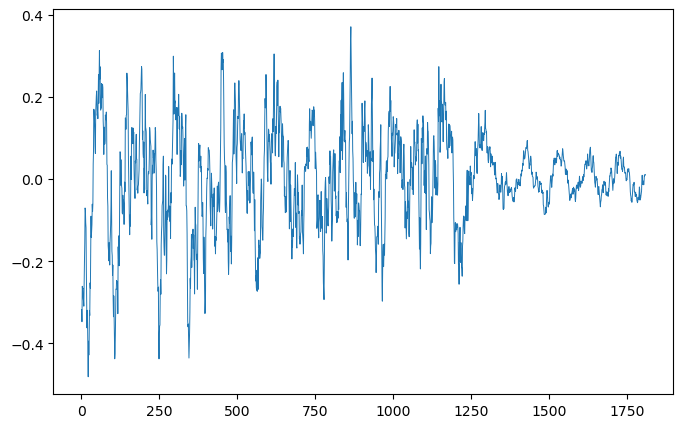

In [26]:
# Create order parameter
ang_order = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    if not i == 0:
        frame_info = vwr_df[vwr_df['FRAME'] == i]
        
        order = 0

        for _, agent in frame_info.iterrows():
            r = np.array([agent['POSITION_X'], agent['POSITION_Y']])
            r = r/np.linalg.norm(r)

            v = np.array([agent['VELOCITY_X'], agent['VELOCITY_Y']])
            v = v/np.linalg.norm(v)
            
            order += np.dot(v, r)
        
        ang_order[i] = order/(len(frame_info))  

fig = plt.figure(figsize=(8, 5))
plt.plot(frames[1:], ang_order[1:], linewidth=0.7)
plt.show()

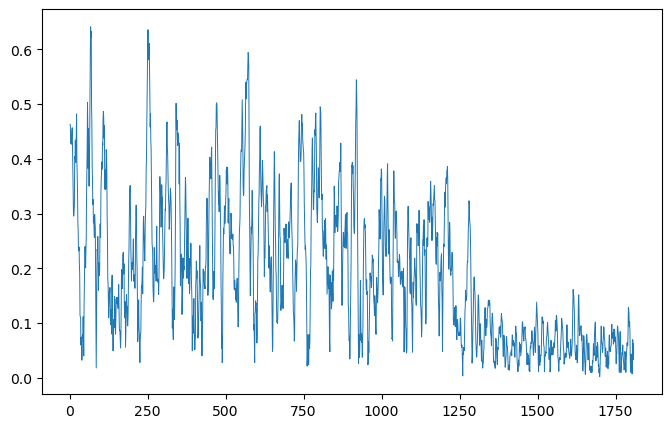

In [27]:
# Create order parameter
ang_order = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    if not i == 0:
        frame_info = vwr_df[vwr_df['FRAME'] == i]
        
        v0 = np.mean(frame_info['VELOCITY_MAG'])
        N = len(frame_info)
        
        v_tot = np.array([sum(frame_info['VELOCITY_X']), sum(frame_info['VELOCITY_Y'])])
        ang_order[i] = (np.sqrt(v_tot[0]**2 + v_tot[1]**2))/(N*v0)
        #ang_order[i] = 1- abs(v_tot[0] + v_tot[1])/(N*v0)


fig = plt.figure(figsize=(8, 5))
plt.plot(frames[1:], ang_order[1:], linewidth=0.7)
plt.show()

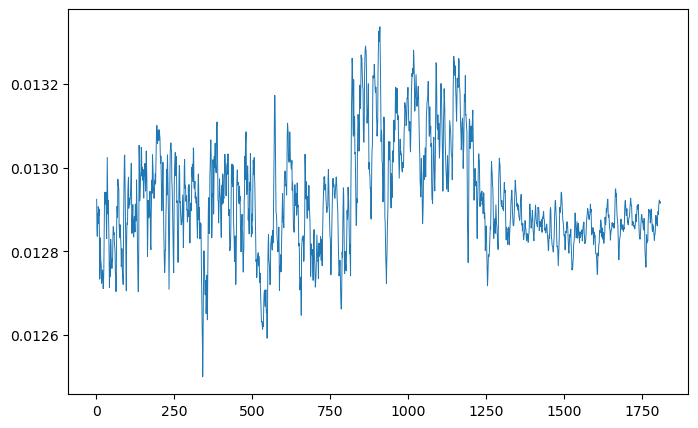

In [28]:
# Create order parameter
ang_order = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    if not i == 0:
        frame_info = vwr_df[vwr_df['FRAME'] == i]
        
        v_max = sum(frame_info['VELOCITY_MAG'])
        order = np.zeros(2)
        
        for _, agent in frame_info.iterrows():
            r = np.array([agent['POSITION_X'], agent['POSITION_Y']])
            r = r/np.linalg.norm(r)

            v = agent['VELOCITY_MAG']
            v = v/v_max
            
            order += v*r
        
        ang_order[i] = (np.linalg.norm(order))/(len(frame_info))  

fig = plt.figure(figsize=(8, 5))
plt.plot(frames[1:], ang_order[1:], linewidth=0.7)
plt.show()

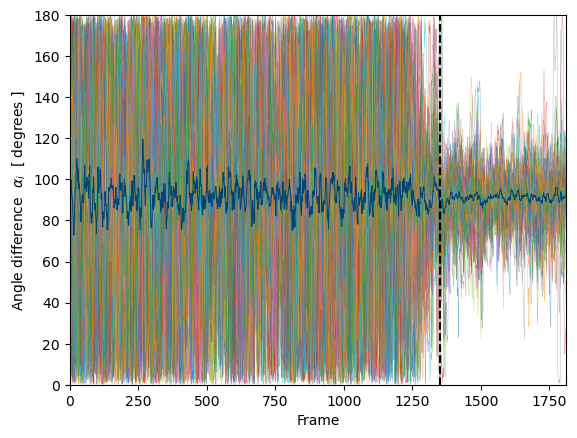

In [29]:
for a in pd.unique(vwr_df['TRACK_ID']):
    agent_info = vwr_df[vwr_df['TRACK_ID'] == a]
    plt.plot(agent_info['FRAME'], agent_info['ANGLE_DIFF'], linewidth=0.3, alpha=0.6)

plt.plot(pd.unique(vwr_df['FRAME']), avg_angv, color='#004474', linewidth=0.7)

plt.xlim(0, 1810)
plt.ylim(0, 180)
plt.vlines(x=1350, ymin=0, ymax=180, linestyles='--', color='k')
plt.ylabel('Angle difference  $\\alpha_i$  [ degrees ]')
plt.xlabel('Frame')
plt.savefig('angle_diff.pdf', format='pdf')
plt.show()

# 95% of the balls